# MLP Project (T2 2023) by Ganesh P  

`Disclaimer`   

> This final notebook contains only the most relevant code to show the path/flow of my project work over few weeks. Rest of the code is in [my github repo](https://github.com/ganeshbmc/MLP_project) which is private at present (I will make it public after the project is over).  

`Overview`  

`PART I`  

1.	> Screen the datasets and import them.  
2.	> Perform EDA (first round).
3.	> Data cleaning.
4.	> Basic models including dummy model.
5.	> Because this is a text sentiment analysis project, focus on 'reviewText' column, work on cleaning text data and vectorising/tokenising it, build several models till the best possible score is reached.  

`PART II`  

6.	> Merge train and movies dataset.
7.	> Perform EDA (second round) on merged dataset.
8.	> Data cleaning.
9.	> Build models on merged dataset.
10.	> Understand the results and do another round of EDA if needed.
11.	> Build final model.  

`PART III (After project window closes)`  

12. > Use NLTK library for further processing text data.  
13. > Try to address comments from different languages, special characters etc.  
14. > Try imblearn library to address class imbalance.  
15. > Try to use currently available LLMs and see how my model performs agains them.  

`Default code on Kaggle notebook`  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


## Import remaining libraries  

In [176]:
# import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from itertools import compress

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE

import lightgbm as ltb

import scipy.stats as stats
print("Imports done.")

Imports done.


## Load datasets  

In [3]:
traindf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
traindf.shape

(162758, 5)

In [4]:
testdf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
testdf.shape

(55315, 4)

## Understanding the data and getting it ready for training and evaluating models  

`Handle missing data. Current strategy is to fill in some custom text.`  
`Separate features and labels from traindf`  
`Split training data into training and testing parts`

In [5]:
traindf.shape

(162758, 5)

In [6]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


In [7]:
traindf.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

### Fill empty reviewText with custom text  

In [8]:
traindf["reviewText"].fillna("empty", inplace=True)
traindf.isna().sum()

movieid               0
reviewerName          0
isFrequentReviewer    0
reviewText            0
sentiment             0
dtype: int64

## EDA  
`Currently in a separate file in github repo`  

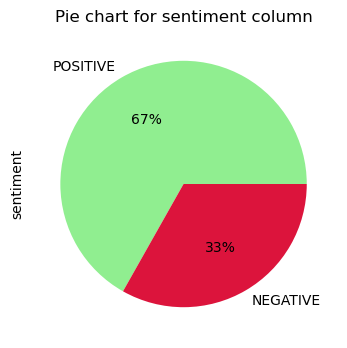

In [9]:
# Pie chart for sentiment column
plt.figure(figsize=(6, 4))
traindf["sentiment"].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["lightgreen", "crimson"])
plt.title("Pie chart for sentiment column")
plt.show()

In [10]:
# Chi-square test for isFrequentReviewer column and sentiment column   

contingency_table = pd.crosstab(traindf['isFrequentReviewer'], traindf['sentiment'])
print(contingency_table)
stats.chi2_contingency(contingency_table)

sentiment           NEGATIVE  POSITIVE
isFrequentReviewer                    
False                  35760     77429
True                   18237     31332


Chi2ContingencyResult(statistic=419.89235425657796, pvalue=2.5755894769493255e-93, dof=1, expected_freq=array([[37551.86493444, 75637.13506556],
       [16445.13506556, 33123.86493444]]))

### Separate features and labels  

In [11]:
train_features = traindf["reviewText"]
train_labels = traindf.iloc[:, -1]
train_features.shape, train_labels.shape

((162758,), (162758,))

### Split traindf into training and testing parts  

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((122068,), (40690,), (122068,), (40690,))

### Needs further exploration  

`stratify based on reviewer type?`  

## Model evaluation plan and code  

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

In [14]:
def evaluate(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    # print(f1_score(y_test, y_pred))
    ConfusionMatrixDisplay(y_test, y_pred)
    return

# Data preprocessing  

## Define stop words  

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [16]:
# stop_words = ["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]
# type(stop_words), len(stop_words)

## Feature extraction  

### Understand CountVectorizer and TfidfVectorizer  

In [17]:
# text = X_train.copy()
# text.head()

In [18]:
# vectorizer = TfidfVectorizer(stop_words=stop_words)
# vectorized_text = vectorizer.fit_transform(text["reviewText"])
# vectorized_text

`Without stop words`  
<122068x58624 sparse matrix of type '<class 'numpy.float64'>'
	with 2312222 stored elements in Compressed Sparse Row format>

`With stop words`  
<122068x57784 sparse matrix of type '<class 'numpy.float64'>'
	with 1188395 stored elements in Compressed Sparse Row format>   

In [19]:
# vectorizer2 = CountVectorizer(stop_words=stop_words)
# vectorized_text2 = vectorizer2.fit_transform(text["reviewText"])
# vectorized_text2

`Without stop words`  
<122068x58624 sparse matrix of type '<class 'numpy.int64'>'
	with 2312222 stored elements in Compressed Sparse Row format>

`With stop words`  
<122068x57784 sparse matrix of type '<class 'numpy.int64'>'
	with 1188395 stored elements in Compressed Sparse Row format>

### Conclusion   
`TfidfVectorizer is equivalent to CountVectorizer followed by TfidfTransformer.`  

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

## Model building workflow  

`Make pipeline for preprocesing and model training and predictions`  


In [20]:
from sklearn.pipeline import Pipeline

In [21]:
def preprocess_n_train(X_train, y_train, preprocessor, model):
    pipe = Pipeline(steps=[
                            ("preprocessor", preprocessor),
                            ("model", model)
                        ])
    
    pipe.fit(X_train, y_train)

    print("Given model has been trained. Use predict method to get predictions array.")
    return pipe


def predict_n_evaluate(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    print(f"y_pred shape: {y_pred.shape}")
    print(f"Summary of predictions: {np.unique(y_pred, return_counts=True)}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return y_pred

# def evaluate(y_test, y_pred):
#     print(classification_report(y_test, y_pred))
#     print(confusion_matrix(y_test, y_pred))
#     # print(f1_score(y_test, y_pred))
#     ConfusionMatrixDisplay(y_test, y_pred)
#     return

## Preprocessor(s)  

In [22]:
tvec = TfidfVectorizer()
# tvec_sw = TfidfVectorizer(stop_words=stop_words)

## Logistic Regression with TfidVectorizer for preprocessing  

In [23]:
from sklearn.linear_model import LogisticRegression

In [24]:
logreg = LogisticRegression(max_iter=1000)
logreg

LogisticRegression(max_iter=1000)

In [25]:
# tvec = TfidfVectorizer()
# cvec = CountVectorizer()        # Note that TfidfVectorizer and CountVectorizer+TfidsTransformer do the same function
# tvec, cvec

In [26]:
# logreg_pipe = preprocess_n_train(X_train, y_train, tvec, logreg)
# logreg_pipe

In [27]:
# y_pred_logreg = predict_n_evaluate(logreg_pipe, X_test, y_test)
# y_pred_logreg

### Logistic Regression with stop words  

In [28]:
# tvec_sw = TfidfVectorizer(stop_words=stop_words)

In [29]:
# logreg_sw_pipe = preprocess_n_train(X_train, y_train, tvec_sw, logreg)
# logreg_sw_pipe

In [30]:
# y_pred_logreg_sw = predict_n_evaluate(logreg_sw_pipe, X_test, y_test)
# y_pred_logreg_sw

### Logistic regression with different ngram ranges  

#### ngram range (1,2)  

In [31]:
# tvec_ngram_2 = TfidfVectorizer(ngram_range=(1,2))

In [32]:
# logreg_ng2_pipe = preprocess_n_train(X_train, y_train, tvec_ngram_2, logreg)
# logreg_ng2_pipe

In [33]:
# y_pred_logreg_ng2 = predict_n_evaluate(logreg_ng2_pipe, X_test, y_test)
# y_pred_logreg_ng2

### Logistic regression with C=2, ngram range (1,2), stop words as None and min_df, max_df adjusted
### Class weight balanced

In [34]:
# logreg = LogisticRegression(max_iter=100000, C=2, class_weight="balanced")

In [35]:
# tvec_ngram_2_sw_df = TfidfVectorizer(ngram_range=(1,2), stop_words=None, min_df=0.0001, max_df=0.50)
# tvec_ngram_2_sw_df

In [36]:
# logreg_ng2_sw_df_pipe = preprocess_n_train(X_train, y_train, tvec_ngram_2_sw_df, logreg)
# logreg_ng2_sw_df_pipe

In [37]:
# y_pred_logreg_ng2_sw_df = predict_n_evaluate(logreg_ng2_sw_df_pipe, X_test, y_test)
# y_pred_logreg_ng2_sw_df

## Log reg with parameters from GridSearchCV  

`This is the best score with "reviewText column alone for analysis`  

In [38]:
logreg_cv1 = LogisticRegression(max_iter=100000, C=10)
tvec_cv1 = TfidfVectorizer(max_features=None, ngram_range=(1,2))

In [39]:
pipe_cv1 = Pipeline(steps=[
    ("preprocessor", tvec_cv1),
    ("model", logreg_cv1)
])

In [40]:
# pipe_cv1.fit(X_train, y_train)

In [41]:
# pipe_cv1.score(X_train, y_train)

## SVM model  

In [42]:
# from sklearn.svm import LinearSVC

In [43]:
# svm = LinearSVC()
# svm

In [44]:
# svm_pipe = preprocess_n_train(X_train, y_train, tvec, svm)
# svm_pipe

In [45]:
# y_pred_svm = predict_n_evaluate(svm_pipe, X_test, y_test)
# y_pred_svm

### SVM model with stop words  

In [46]:
# svm_sw_pipe = preprocess_n_train(X_train, y_train, tvec_sw, svm)
# svm_sw_pipe

In [47]:
# y_pred_svm_sw = predict_n_evaluate(svm_sw_pipe, X_test, y_test)
# y_pred_svm_sw

## Naive Bayes model  

### MultinomialNB  

In [48]:
# from sklearn.naive_bayes import GaussianNB, BernoulliNB, CategoricalNB, ComplementNB, MultinomialNB

In [49]:
# mnb = MultinomialNB()
# mnb

In [50]:
# mnb_pipe = preprocess_n_train(X_train, y_train, tvec, mnb)
# mnb_pipe

In [51]:
# y_pred_mnb = predict_n_evaluate(mnb_pipe, X_test, y_test)
# y_pred_mnb

### GaussianNB  

https://stackoverflow.com/questions/28384680/scikit-learns-pipeline-a-sparse-matrix-was-passed-but-dense-data-is-required

In [52]:
# gnb = GaussianNB()
# gnb

In [53]:
# gnb_pipe = preprocess_n_train(X_train, y_train, tvec, gnb)
# gnb_pipe

## Submitting predictions to Kaggle competition  

In [54]:
def submit(selected_model=logreg, selected_preprocessor=tvec):
    
    # Retrain on the whole train.csv file  
    traindf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
    X_train = traindf["reviewText"]
    X_train.fillna("empty", inplace=True)
    y_train = traindf["sentiment"]
    pipe = preprocess_n_train(X_train, y_train, selected_preprocessor, selected_model)
    
    # Predict on test.csv file
    testdf = pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")
    X_test = testdf["reviewText"]
    X_test.fillna("empty", inplace=True)
    
    y_pred = pipe.predict(X_test)
    
    pred_df = pd.DataFrame(y_pred)
    pred_df.columns = ["sentiment"]
    pred_df.index.name = "id"
    pred_df.to_csv("submission.csv")
    
    return "Successfully created the submission file!!!"

In [55]:
# submit(logreg_cv1, tvec_cv1)

## Part 2: Merge "movies.csv" with "train.csv" to see if score improves  

### Custom functions  

In [56]:
def load_csv(filename: str):
    df = pd.read_csv(f"/kaggle/input/sentiment-prediction-on-movie-reviews/{filename}.csv")
    return df

In [57]:
def inspect(df: pd.DataFrame):
    print(f"Shape of the dataframe: {df.shape}")
    print()
    print(f"Columns in the dataframe:\n{df.columns}")
    print()
    print(f"{df.info()}")
    print()
    # print(f"Summary: {df.describe()}")
    print(f"Missing values:\n{df.isna().sum()}")
    return

In [58]:
def name_fl(name):
    l = name.split()
    n = ' '.join((l[0], l[-1]))
    return n

In [59]:
def select_features(df: pd.DataFrame, moviesdf: pd.DataFrame):
    '''
    This function merges the given dataframes. Note that the first df must be "train" or "test" and
    the second df should be "movies".
    Note: Sentiment column is present only in "train.csv" file and not "test.csv" file.
    '''
    
    # Drop duplicates from moviesdf
#     movies_unique = moviesdf.drop_duplicates(subset=["movieid"])
    # Drop duplicates using groupby - clubs similar rows and fills in missing values better
    movies_unique = moviesdf.fillna(value=np.nan).groupby("movieid").first()

    # Merge df and movies_unique
    df_merged = pd.merge(df, movies_unique, on="movieid", how='left')
    
    # Rename "isTopCritic" column, if it exists, to "isFrequentReviewer"
    df_merged.rename(columns={"isTopCritic": "isFrequentReviewer"}, inplace=True)
    
    # Drop columns
    df_merged = df_merged.drop(columns=["title", "ratingContents", "releaseDateTheaters", "releaseDateStreaming", "distributor", "soundType"])

    # Fill missing values in "reviewText" with empty string
    final = df_merged.copy()
    final["reviewYN"] = np.where(final["reviewText"].isnull(), 1, 0)    # Feature engineering - adding a new column
    final["reviewWC"] = final.apply(lambda x: len(str(x["reviewText"]).split()), axis=1)    # Feature engineering - adding second new column
    final["reviewText"] = final["reviewText"].fillna("neutral")
    
    # Fill missing values in "rating", "genre", original columns with the word "Unknown"
    final["rating"] = final["rating"].fillna("Unknown")
    final["genre"] = final["genre"].fillna("Unknown")
    final["originalLanguage"] = final["originalLanguage"].fillna("Unknown")

    # Impute missing values for "audienceScore" and "runtimeMinutes" columns
    final["audienceScore"] = final["audienceScore"].fillna(final["audienceScore"].mean())
    final["runtimeMinutes"] = final["runtimeMinutes"].fillna(final["runtimeMinutes"].median())
    
    # Preprocess and impute missing values in "boxOffice" column
    final["boxOffice"] = final["boxOffice"].str[1:]
    final["boxOffice"] = final["boxOffice"].replace(to_replace={"M": "*1000000", "K": "*1000"}, regex=True)
    final["boxOffice"] = final["boxOffice"].loc[final["boxOffice"].notnull()].apply(lambda x: eval(str(x)))
    final["boxOffice"] = final["boxOffice"].fillna(final["boxOffice"].median())
    # (Optional) Replace outliers in boxOffice with median
    median = final["boxOffice"].describe()['50%']
    iqr = final["boxOffice"].describe()['75%'] - final["boxOffice"].describe()['25%']
    ll = median - (1.5*iqr)
    ul = median + (1.5*iqr)
    final.loc[final["boxOffice"] > ul, "boxOffice"] = median
    
    # Clean language names
    final["originalLanguage"].replace({"English (United Kingdom)": "English", 
                                            "English (Australia)" : "English",
                                            "French (France)": "French", 
                                            "French (Canada)": "French",
                                            "Portuguese (Brazil)": "Portuguese",
                                            "Spanish (Spain)": "Spanish"},                                         
                                            inplace=True)
    
    # Clean reviewerName column
    pre_post_fixes = {"Mr. ": "", "Mrs. ": "", "Ms. ": "", "Dr. ": "", 
                      " MD": "", " DDS": "", " DVM": "", " Jr.": "", " PhD": "", " II": "", " IV": ""}
    final["reviewerName"] = final["reviewerName"].replace(pre_post_fixes, regex=True)
    final["reviewerName"] = final["reviewerName"].apply(name_fl)

    return final

In [60]:
def split_train_predict(features, labels, pipeline, test_size=0.25, random_state=42):
    # cols = features.columns
    if len(features.shape) == 1:
        features = features.to_numpy().reshape(-1, 1)  # reshape to 2D array
    features = pd.DataFrame(features)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, random_state=random_state)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    return pipeline

### Merge "train.csv" file with "movies.csv" file  

In [61]:
merged = select_features(load_csv("train"), load_csv("movies"))
inspect(merged)

Shape of the dataframe: (162758, 14)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'sentiment', 'audienceScore', 'rating', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director', 'boxOffice', 'reviewYN', 'reviewWC'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieid             162758 non-null  object 
 1   reviewerName        162758 non-null  object 
 2   isFrequentReviewer  162758 non-null  bool   
 3   reviewText          162758 non-null  object 
 4   sentiment           162758 non-null  object 
 5   audienceScore       162758 non-null  float64
 6   rating              162758 non-null  object 
 7   runtimeMinutes      162758 non-null  float64
 8   genre               162758 non-null  object 
 9   originalLanguage    162758

In [62]:
merged["reviewText"].head()

0    Henry Selick’s first movie since 2009’s Corali...
1    With a cast that reads like the Vogue Oscar pa...
2    Creed II does not give us anything but another...
3    I know what you're thinking, but this is no Li...
4    Director Fernando Meirelles tells the story wi...
Name: reviewText, dtype: object

In [63]:
merged["reviewYN"].sum()

6447

In [64]:
merged["reviewWC"].head()

0    11
1    24
2    22
3    34
4    20
Name: reviewWC, dtype: int64

In [65]:
merged["reviewWC"].describe()

count    162758.000000
mean         21.013707
std          10.216532
min           1.000000
25%          14.000000
50%          21.000000
75%          28.000000
max          54.000000
Name: reviewWC, dtype: float64

<Axes: xlabel='reviewWC', ylabel='Count'>

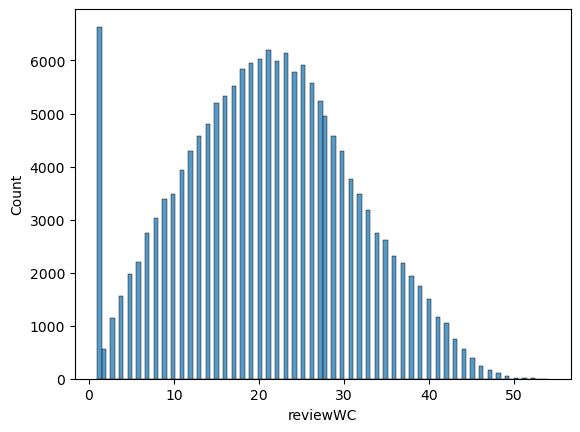

In [66]:
sns.histplot(merged["reviewWC"])

In [67]:
merged['rating'].value_counts()

R          60248
Unknown    44587
PG-13      42697
PG         13669
TV14         947
NC-17        285
TVPG         281
TVMA          44
Name: rating, dtype: int64

In [68]:
merged['isFrequentReviewer'].value_counts()

False    113189
True      49569
Name: isFrequentReviewer, dtype: int64

In [69]:
merged["reviewerName"].head()

0      Benjamin Henry
1       Felicia Lopez
2     Charles Burgess
3        Ryan Barrett
4    Alexander Glover
Name: reviewerName, dtype: object

In [70]:
merged['boxOffice'].value_counts()

14300000.0    57634
2000000.0       922
1100000.0       891
1000000.0       834
1200000.0       802
              ...  
283100.0          1
58500.0           1
500800.0          1
813700.0          1
799400.0          1
Name: boxOffice, Length: 3130, dtype: int64

In [71]:
# Check correlation between 'boxOffice' and ''sentiment'
# bo_df = merged.copy()
# print(bo_df["boxOffice"])
# bo_df["boxOffice"] = bo_df["boxOffice"].str[1:]
# bo_df["boxOffice"] = bo_df["boxOffice"].replace(to_replace={"M": "*1000000", "K": "*1000"}, regex=True)
# bo_df["boxOffice"] = bo_df["boxOffice"].loc[bo_df["boxOffice"].notnull()].apply(lambda x: eval(str(x)))
# bo_df["boxOffice"] = bo_df["boxOffice"].fillna(bo_df["boxOffice"].median())
# bo_df["boxOffice"].describe()

In [72]:
# median = bo_df["boxOffice"].describe()['50%']
# iqr = bo_df["boxOffice"].describe()['75%'] - bo_df["boxOffice"].describe()['25%']
# median, iqr

In [73]:
# ll = median - (1.5*iqr)
# ul = median + (1.5*iqr)
# ll, ul

In [74]:
# bo_df["boxOffice"].mean()

In [75]:
# bo_df.loc[bo_df["boxOffice"] > ul, "boxOffice"] = median
# bo_df["boxOffice"].mean()

In [76]:
# bo_df["boxOffice"].min(), bo_df["boxOffice"].max()

In [77]:
# sns.boxplot(x="sentiment", y="boxOffice", data=bo_df, showfliers = False)

## EDA  

### An interesting finding through exploration  
  
* OHE and TfidfVectorizer on director column give the same result when ngram_range(2,2) is used (see code below)!

In [78]:
# Compare OHE and TfidfVectorizer on director column

dirs = merged["director"].copy()
print(dirs.shape)
dirs_uniq = merged["director"].unique()
print(len(dirs_uniq))

du_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit_transform(dirs.to_numpy().reshape(-1, 1))
print(du_ohe.shape, type(du_ohe))

dirs_2 = merged["director"].copy()
print(dirs_2.shape)
du_tfidf = TfidfVectorizer(ngram_range=(2,2)).fit_transform(dirs_2).toarray()
print(du_tfidf.shape, type(du_tfidf))

print(np.array_equal(du_ohe, du_tfidf))

(162758,)
9476
(162758, 9476) <class 'numpy.ndarray'>
(162758,)
(162758, 9476) <class 'numpy.ndarray'>
True


In [79]:
print(dirs.head())
d = dirs.copy()
d["name_len"] = d.apply(lambda x: len(x.split()))
d["name_len"].value_counts()

0       Bennie Basso
1         Alma White
2       Bobby Oleary
3    Eric Hutcherson
4         John Trent
Name: director, dtype: object


2    162758
Name: director, dtype: int64

In [80]:
# Compare OHE and TfidfVectorizer on reviewerName column
# Note: reviewerName column has salutations like "Mr. " etc, and some names appear middle names. Therefore needs cleaning

# def name_fl(name):
#     l = name.split()
#     n = ' '.join((l[0], l[-1]))
#     return n

# reviewers = merged["reviewerName"].copy()
# reviewers = pd.DataFrame(reviewers)
# reviewers = reviewers.replace({"Mr. ": "", "Mrs. ": ""}, regex=True)
# reviewers["reviewerName"] = reviewers["reviewerName"].apply(name_fl)
# print(reviewers.shape)

# reviewers_uniq = merged["reviewerName"].unique()
# print(len(reviewers_uniq))

# reviewers_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False).fit_transform(reviewers.to_numpy().reshape(-1, 1))
# print(reviewers_ohe.shape, type(reviewers_ohe))

# reviewers_2 = merged["reviewerName"].copy()
# reviewers_2 = pd.DataFrame(reviewers_2)
# print(reviewers_2.head())
# reviewers_2 = reviewers_2.replace({"Mr. ": "", "Mrs. ": ""}, regex=True)
# reviewers_2["reviewerName"] = reviewers_2["reviewerName"].apply(name_fl)
# reviewers_2 = reviewers_2.squeeze()
# print(reviewers_2.shape)
# print(reviewers_2.head())

# reviewers_tfidf = TfidfVectorizer(ngram_range=(2,2)).fit_transform(reviewers_2).toarray()
# print(reviewers_tfidf.shape, type(reviewers_tfidf))

# print(np.array_equal(reviewers_ohe, reviewers_tfidf))

In [81]:
# def name_fl(name):
#     l = name.split()
#     n = ' '.join((l[0], l[-1]))
#     return n

In [82]:
# print(reviewers.head())
# r = pd.DataFrame(reviewers.copy())
# r["reviewerName"] = r["reviewerName"].apply(name_fl)
# r["name_len"] = r["reviewerName"].apply(lambda x: len(x.split()))
# print(r.shape)
# print(r.head())
# print(r['name_len'].value_counts())

In [83]:
## Box plot audienceScore and sentiment  
# plt.figure(figsize=(6, 4))
# sns.boxplot(x="sentiment", y="audienceScore", data=merged, width=0.3)
# plt.title("Box plot audienceScore and sentiment")
# plt.show()

In [84]:
## Box plot runtimeMinutes and sentiment  
# plt.figure(figsize=(6, 4))
# sns.boxplot(x="sentiment", y="runtimeMinutes", data=merged, width=0.3)
# plt.title("Box plot runtimeMinutes and sentiment")
# plt.show()

In [85]:
## Column chart for sentiment and rating columns
# plt.figure(figsize=(6, 4))
# sns.countplot(x="sentiment", hue="rating", data=merged)
# plt.title("Column chart for sentiment and rating columns")
# plt.show()

In [86]:
# Correlation heatmap  
# plt.figure(figsize=(10, 8))
# sns.heatmap(merged.corr(), annot=True, cmap="coolwarm")
# plt.title("Correlation heatmap")
# plt.show()

### Separate features and labels from merged dataset  

In [87]:
merged_train_features = merged[['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director']]
merged_train_features.shape

(162758, 10)

In [88]:
merged_train_labels = merged["sentiment"]
merged_train_labels.shape

(162758,)

### Identify variable types for different preprocessing pipes  

In [89]:
num_vars = ["audienceScore", "runtimeMinutes"]
txt_vars = ["originalLanguage", "genre", "director", "reviewerName", "reviewText"]
cat_vars = ["rating", "isFrequentReviewer"]

In [90]:
num_pipe = Pipeline(steps=[
                            ("imputer", SimpleImputer(strategy="mean", missing_values=np.nan)),
                            ("scaler", MinMaxScaler())
                        ])
num_pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler())])

In [91]:
txt_pipe = Pipeline(steps=[
                            ("tvec", TfidfVectorizer())
                        ])
txt_pipe

Pipeline(steps=[('tvec', TfidfVectorizer())])

In [92]:
cat_pipe = Pipeline(steps=[
                            ("ohe", OneHotEncoder(handle_unknown="ignore"))
                        ])
cat_pipe

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

In [93]:
tfidf_vec_1 = TfidfVectorizer(ngram_range=(1,2))
tfidf_vec_1

TfidfVectorizer(ngram_range=(1, 2))

In [94]:
ct_final = ColumnTransformer(transformers=[
                                        ("num", num_pipe, num_vars),
                                        ("txt1", txt_pipe, "originalLanguage"),
                                        ("txt2", txt_pipe, "genre"),
                                        ("txt3", txt_pipe, "director"),
                                        ("cat", cat_pipe, cat_vars),
                                        ("txt4a", tfidf_vec_1, "reviewText")
#                                         ("txt4", TfidfVectorizer(ngram_range=(1,2)), "reviewText"),
#                                         ("cat2", cat_pipe, ["isFrequentReviewer"])
                                        ], remainder="drop", n_jobs=1)

# Note that this transformer drops "movieid" column and "reviewerName" column  
ct_final

ColumnTransformer(n_jobs=1,
                  transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['audienceScore', 'runtimeMinutes']),
                                ('txt1',
                                 Pipeline(steps=[('tvec', TfidfVectorizer())]),
                                 'originalLanguage'),
                                ('txt2',
                                 Pipeline(steps=[('tvec', TfidfVectorizer())]),
                                 'genre'),
                                ('txt3',
                                 Pipeline(steps=[('tvec', TfidfVectorizer())]),
                                 'director'),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['rating', 'isFrequentReviewer']),
                                ('txt4a', TfidfVectorizer(ngram_range=(1, 2)),
                                 'reviewText')])

In [95]:
pipe_final = Pipeline(steps=[
                        ("preprocessor", ct_final),
                        ("model", LogisticRegression(max_iter=100000))
                    ])
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['audienceScore',
                                                   'runtimeMinutes']),
                                                 ('txt1',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'originalLanguage'),
                                                 ('txt2',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'genre'),
                                                 ('txt3',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer())]),
                                                  'director'),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['rating',
                                                   'isFrequentReviewer']),
                                                 ('txt4a',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'reviewText')])),
                ('model', LogisticRegression(max_iter=100000))])

In [96]:
final_vars = num_vars + txt_vars + cat_vars
len(final_vars), final_vars

(9,
 ['audienceScore',
  'runtimeMinutes',
  'originalLanguage',
  'genre',
  'director',
  'reviewerName',
  'reviewText',
  'rating',
  'isFrequentReviewer'])

In [97]:
# split_train_predict(merged_train_features, merged_train_labels, pipe_final, test_size=0.25, random_state=42)

### Merge and preprocess "test.csv" and "movies.csv" files  

In [98]:
merged_test = select_features(load_csv("test"), load_csv("movies"))
inspect(merged_test)

Shape of the dataframe: (55315, 13)

Columns in the dataframe:
Index(['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre',
       'originalLanguage', 'director', 'boxOffice', 'reviewYN', 'reviewWC'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieid             55315 non-null  object 
 1   reviewerName        55315 non-null  object 
 2   isFrequentReviewer  55315 non-null  bool   
 3   reviewText          55315 non-null  object 
 4   audienceScore       55315 non-null  float64
 5   rating              55315 non-null  object 
 6   runtimeMinutes      55315 non-null  float64
 7   genre               55315 non-null  object 
 8   originalLanguage    55315 non-null  object 
 9   director            55315 non-null  object 
 10  boxO

In [99]:
print(merged_test["reviewYN"].sum())
print(merged_test["reviewYN"].sum() * 100 / merged_test.shape[0])

2510
4.537648015908886


In [100]:
merged_test['rating'].value_counts()

R          18934
Unknown    18386
PG-13      13220
PG          4200
TV14         333
TVPG         109
NC-17        108
TVMA          25
Name: rating, dtype: int64

In [101]:
merged_test['isFrequentReviewer'].value_counts()

False    38428
True     16887
Name: isFrequentReviewer, dtype: int64

In [102]:
merged_test['boxOffice'].value_counts()

12200000.0    22550
1100000.0       311
1000000.0       272
1300000.0       263
2000000.0       256
              ...  
117100.0          1
174500.0          1
216200.0          1
279600.0          1
100600.0          1
Name: boxOffice, Length: 3024, dtype: int64

## Try the best four features obtained on local machine  

In [103]:
tfidf_vec_2 = TfidfVectorizer(ngram_range=(1,2))
tfidf_vec_2

TfidfVectorizer(ngram_range=(1, 2))

In [104]:
ct_best4 = ColumnTransformer(transformers=[
                                            ("num", num_pipe, ["audienceScore"]),
                                            ("cat", cat_pipe, ["rating", "isFrequentReviewer"]),
                                            ("tvec", tfidf_vec_2, "reviewText")
                            ])

pipe_best4 = Pipeline(steps=[
    ("preprocessor", ct_best4),
    ("model", LogisticRegression())
])

pipe_best4.set_params(model__C=10, model__max_iter=100000)

pipe_best4

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['audienceScore']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['rating',
                                                   'isFrequentReviewer']),
                                                 ('tvec',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'reviewText')])),
                ('model', LogisticRegression(C=10, max_iter=100000))])

In [105]:
# split_train_predict(merged[["audienceScore", "rating", "isFrequentReviewer", "reviewText"]], merged["sentiment"], pipe_best4, test_size=0.25)

## Try only 'reviewText' column  

In [106]:
tfidf_vec_3 = TfidfVectorizer(ngram_range=(1,2))
tfidf_vec_3

TfidfVectorizer(ngram_range=(1, 2))

In [107]:
ct_RTonly = ColumnTransformer(transformers=[
                                            ('txt', tfidf_vec_3, 'reviewText'),
                                            ], remainder='drop')
ct_RTonly

ColumnTransformer(transformers=[('txt', TfidfVectorizer(ngram_range=(1, 2)),
                                 'reviewText')])

In [108]:
pipe_RTonly = Pipeline(steps=[
    ("preprocessor", ct_RTonly),
    ("model", LogisticRegression())
])

pipe_RTonly.set_params(model__C=10, model__max_iter=100000)

pipe_RTonly

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('txt',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2)),
                                                  'reviewText')])),
                ('model', LogisticRegression(C=10, max_iter=100000))])

## Submit_v4 for merged file models  

In [109]:
# Testing predictions on missing reviewtext columns  

def predict_on_missing_review_data(pipe, selected_features, merged_train):
    missing_reviews_train = merged_train.loc[merged_train['reviewYN'] == 1]
    missing_reviews_train.reset_index(drop=True)
    X_train_miss_revs = missing_reviews_train.drop('sentiment', axis = 1)
    X_train_miss_revs = X_train_miss_revs[selected_features]
    y_train_miss_revs = missing_reviews_train['sentiment']
    
    y_pred_miss_revs = pipe.predict(X_train_miss_revs)
    print('Predictions on rows which had missing reviewText')
    print(confusion_matrix(y_train_miss_revs, y_pred_miss_revs))
    return f1_score(y_train_miss_revs, y_pred_miss_revs, average='micro')

In [187]:
def build_pipeline(selected_model=LogisticRegression(), 
                   selected_features={'txt': ['reviewText']}, 
                   param_grid=None,
                   vocab=None):
    # Encoders  
    ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
    scaler = MinMaxScaler()
    
    # Text features ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']
    tfidf_vec = TfidfVectorizer(ngram_range=(1,2))
    txt_pipe = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(1,2)))
                        ])
    txt_pipe_2 = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(2,2)))
                        ])
    txt_pipe_3 = Pipeline(steps=[
                            ("tvec", TfidfVectorizer(ngram_range=(1,1)))
                        ])
    # Basic pipes  
    TFs = []
    try:
        for c in selected_features['cat']:
            TFs.append((f"cat_{c}", ohe, [c]))
    except:
        pass
    try:
        for n in selected_features['num']:
            TFs.append((f"num_{n}", scaler, [n]))
    except:
        pass
    try:
        for t in selected_features['txt']:
            if t in ['director', 'reviewerName']:
                TFs.append((f"txt_{t}", txt_pipe_2, t))
            elif t in ['movieid', 'genre']:
                TFs.append((f"txt_{t}", txt_pipe_3, t))
            else:
                if vocab:
                    txt_pipe.set_params(tvec__vocabulary=vocab)
                    txt_pipe.set_params(tvec__stop_words='english')
                TFs.append((f"txt_{t}", txt_pipe, t))
    except:
        pass

    # Build ColumnTransformer  
    ct = ColumnTransformer(transformers=TFs, remainder='drop')

    # Build Pipeline
    pipe = Pipeline(steps=[('ct', ct), ('model', selected_model)])
    
    # GridSearchCV if param_grid provided
    if param_grid:
        pipeCV = GridSearchCV(pipe, param_grid, cv=5, scoring="f1_micro", n_jobs=-1)
        return pipeCV
    
    return pipe

In [111]:
def submit_v4(selected_model=LogisticRegression(C=10, max_iter=100000), 
              selected_features={'txt': ['reviewText']}, 
              param_grid=None,
              vocab=None):

    # Build Pipeline
    pipe = build_pipeline(selected_model, selected_features, param_grid=param_grid, vocab=vocab)
    print(pipe)

    # Features list
    features = []
    for item in selected_features.values():
        features.extend(item)

    # Retrain on the whole train.csv file  
    merged = select_features(load_csv("train"), load_csv("movies"))
    X_train = merged.drop(labels="sentiment", axis=1)
    y_train = merged["sentiment"]

    X_train = X_train[features]
    
    # Check1
    print(X_train.shape)
    print(X_train.head())
    
    if not param_grid:
        try:
            print(pipe.named_steps['model'].intercept_, pipe.named_steps['model'].coef_)
        except:
            print("Model not trained yet!")
    
    # Fit 
    pipe.fit(X_train, y_train)
    
    # Check2
    if not param_grid:
        print(pipe.named_steps['model'].intercept_, pipe.named_steps['model'].coef_)
        print(pipe.score(X_train, y_train))
    else:
        print(pipe.best_params_)
        print(pipe.best_score_)
    print(predict_on_missing_review_data(pipe, features, merged))    # Function defined above
    
        
        
    # Predict on test.csv file
    merged_test = select_features(load_csv("test"), load_csv("movies"))
    X_test = merged_test.copy()

    X_test = X_test[features]
    
    # Check3
    print(X_test.shape)
    print(X_test.head())
    
    y_pred = pipe.predict(X_test)
    
    # Check4
    if not param_grid:
        print(pipe.named_steps['model'].intercept_, pipe.named_steps['model'].coef_)
        print(pipe.score(X_train, y_train))
    else:
        print(pipe.best_params_)
        print(pipe.best_score_)

    
    pred_df = pd.DataFrame(y_pred)
    pred_df.columns = ["sentiment"]
    pred_df.index.name = "id"
    pred_df.to_csv("submission.csv")
    
    return "Successfully created the submission file!!!"

In [112]:
# submit_v4()

#Default params to this function gave a score of 0.8259 - improvement over previous score of 0.82563!

In [113]:
# Try out GridSearchCV
# param_grid = {
#     "model__C": [0.1, 1, 5, 10]
# }

# submit_v4(selected_features={'txt': ['genre']}, param_grid=param_grid)

## Try the best 4 parameters with submit_v4 function

In [114]:
# best4 = ["audienceScore", "rating", "isFrequentReviewer", "reviewText"]
best4_dict = {'cat': ["rating", "isFrequentReviewer"],
             'num': ["audienceScore"],
             'txt': ['reviewText']}
best4_dict

{'cat': ['rating', 'isFrequentReviewer'],
 'num': ['audienceScore'],
 'txt': ['reviewText']}

In [115]:
# submit_v4(selected_features=best4_dict)

## Try the best 3 parameters with submit_v4 function

In [116]:
# best3 = ["audienceScore", "isFrequentReviewer", "reviewText"]
best3_dict = {'cat': ["isFrequentReviewer"],
             'num': ["audienceScore"],
             'txt': ['reviewText']}
best3_dict

{'cat': ['isFrequentReviewer'],
 'num': ['audienceScore'],
 'txt': ['reviewText']}

In [117]:
# submit_v4(selected_features=best3_dict)

## Try throwing almost everything (no boxOffice) at submit_v4!  

In [118]:
"""Most from merged = ['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre', 
       'originalLanguage', 'director']"""

almost_dict = {'cat': ["isFrequentReviewer", "rating", "originalLanguage"],
             'num': ["audienceScore", "runtimeMinutes"],
             'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}
almost_dict

{'cat': ['isFrequentReviewer', 'rating', 'originalLanguage'],
 'num': ['audienceScore', 'runtimeMinutes'],
 'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}

In [119]:
# submit_v4(selected_features=almost_dict)

## Try throwing everything possible at submit_v4!  

In [120]:
"""All from merged = ['movieid', 'reviewerName', 'isFrequentReviewer', 'reviewText',
       'audienceScore', 'rating', 'runtimeMinutes', 'genre', 'boxOffice',
       'originalLanguage', 'director']"""

all_dict = {'cat': ["isFrequentReviewer", "rating", "originalLanguage"],
             'num': ["audienceScore", "runtimeMinutes", "boxOffice"],
             'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}
all_dict

{'cat': ['isFrequentReviewer', 'rating', 'originalLanguage'],
 'num': ['audienceScore', 'runtimeMinutes', 'boxOffice'],
 'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}

In [121]:
# submit_v4(selected_features=all_dict)

## Try GridSearchCV on everything  

In [122]:
# param_grid = {
#     "model__C": [0.5, 2, 5, 15]
# }

# param_grid = {
#     'model__C' : [1, 5],
#     'model__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
# }

# param_grid = {
#     'model__C' : [1, 5],
#     'model__solver': ['lbfgs', 'liblinear', 'sag', 'saga']
# }

param_grid = {
    'model__C' : [1, 5, 10],
    'model__solver': ['lbfgs', 'liblinear', 'saga']
}

param_grid

{'model__C': [1, 5, 10], 'model__solver': ['lbfgs', 'liblinear', 'saga']}

In [123]:
# submit_v4(selected_features={'txt': ["genre"]}, param_grid=param_grid)

In [124]:
# submit_v4(selected_features=all_dict, param_grid=param_grid)

# Best C was 5
# Best solver was liblinear

"""Used 'groupby' function instead on 'drop_duplicates' on movies.csv file. 
It reduced the number of missing values significantly! 
Then used LogisticRegression() with GridSearchCV on submit_v4 function with 
param_grid={'model__C': [1, 5, 10], 'model__solver': ['lbfgs', 'liblinear', 'saga']}. 
The best f1_micro score in GridSearchCV was 0.8399771362056203 which is highest among 
all the versions so far. Best C was 5 and best solver was 'saga'.
Score obtained was 0.84385 which is lower than 0.84441."""

"Used 'groupby' function instead on 'drop_duplicates' on movies.csv file. \nIt reduced the number of missing values significantly! \nThen used LogisticRegression() with GridSearchCV on submit_v4 function with \nparam_grid={'model__C': [1, 5, 10], 'model__solver': ['lbfgs', 'liblinear', 'saga']}. \nThe best f1_micro score in GridSearchCV was 0.8399771362056203 which is highest among \nall the versions so far. Best C was 5 and best solver was 'saga'.\nScore obtained was 0.84385 which is lower than 0.84441."

## Try a new feature dict  



In [125]:
all_dict_new = {'cat': ["isFrequentReviewer", "rating", "originalLanguage"],
             'num': ["audienceScore", "runtimeMinutes", "boxOffice"],
             'txt': ['reviewText', "reviewerName", 'movieid', 'genre', 'director']}
all_dict_new

{'cat': ['isFrequentReviewer', 'rating', 'originalLanguage'],
 'num': ['audienceScore', 'runtimeMinutes', 'boxOffice'],
 'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}

In [126]:
# submit_v4(selected_features={'txt': ['genre']}, param_grid=param_grid)

In [127]:
# submit_v4(selected_features=all_dict_new, param_grid=param_grid)

In [128]:
# Try non-text based columns
num_cat_dict = {'cat': ['isFrequentReviewer', 'rating', 'originalLanguage'],
 'num': ['audienceScore', 'runtimeMinutes', 'boxOffice']}
num_cat_dict

{'cat': ['isFrequentReviewer', 'rating', 'originalLanguage'],
 'num': ['audienceScore', 'runtimeMinutes', 'boxOffice']}

In [129]:
# Use num_cat_dict features
# (Update): Gets a local score of 0.7027181356991726. Not great.
# submit_v4(selected_model=LogisticRegression(max_iter=100000), selected_features=num_cat_dict, param_grid=param_grid)

In [130]:
# Try data other than reviewText

mov_dict = {'cat': ['rating', 'originalLanguage'],
 'num': ['audienceScore', 'runtimeMinutes', 'boxOffice'],
 'txt': ['movieid', 'genre', 'director']}
mov_dict

{'cat': ['rating', 'originalLanguage'],
 'num': ['audienceScore', 'runtimeMinutes', 'boxOffice'],
 'txt': ['movieid', 'genre', 'director']}

In [131]:
# Use mov_dict features
# (Update): Gets a local score of 0.7475454316469369, which is not bad at all.
# submit_v4(selected_model=LogisticRegression(max_iter=100000), selected_features=mov_dict, param_grid=param_grid)

# Try a new column 'reviewYN'  



In [132]:
all_dict_3 = {'cat': ["isFrequentReviewer", "rating", "originalLanguage", "reviewYN"],
             'num': ["audienceScore", "runtimeMinutes", "boxOffice"],
             'txt': ['reviewText', "reviewerName", 'movieid', 'genre', 'director']}
all_dict_3

{'cat': ['isFrequentReviewer', 'rating', 'originalLanguage', 'reviewYN'],
 'num': ['audienceScore', 'runtimeMinutes', 'boxOffice'],
 'txt': ['reviewText', 'reviewerName', 'movieid', 'genre', 'director']}

In [133]:
# submit_v4(selected_model=LogisticRegression(max_iter=100000),
#          selected_features=all_dict_3, 
#           param_grid=param_grid)

## Try LinearSVC with GridSearchCV  

In [134]:
param_grid_svc = {
    "model__C": [0.1, 1, 10, 100]
}
param_grid_svc

{'model__C': [0.1, 1, 10, 100]}

In [135]:
# submit_v4(selected_model=LinearSVC(max_iter=100000, random_state=42), selected_features={'num': ["audienceScore"]}, param_grid=param_grid_svc)

# Comment: LinearSVC even on single column feature set takes too long to converge.

In [136]:
# Throw everything at LinearSVC and hope for it to complete!
# (Update): This took 66 mins to run and gave a public score of 0.84295 (lesser than logreg gridsearchcv wwhich gave 0.84441). Best C was 1.0.

# submit_v4(selected_model=LinearSVC(max_iter=100000, random_state=42), selected_features=all_dict, param_grid=param_grid_svc)


In [137]:
param_grid_svc_2 = {
    'model__C': [1.0],
    'model__loss': ['hinge', 'squared_hinge'],
    'model__class_weight': ['balanced', None]
}
param_grid_svc_2

{'model__C': [1.0],
 'model__loss': ['hinge', 'squared_hinge'],
 'model__class_weight': ['balanced', None]}

In [138]:
# submit_v4(selected_model=LinearSVC(max_iter=100000, random_state=42), selected_features={'num': ["audienceScore"]}, param_grid=param_grid_svc_2)

In [139]:
# submit_v4(selected_model=LinearSVC(max_iter=100000, random_state=42), selected_features=all_dict, param_grid=param_grid_svc_2)

## Try Boosting techniques  

In [140]:
adc = AdaBoostClassifier(estimator=LogisticRegression(C=5, solver="saga", max_iter=100000), n_estimators=50)
adc

AdaBoostClassifier(estimator=LogisticRegression(C=5, max_iter=100000,
                                                solver='saga'))

In [141]:
# submit_v4(selected_model=adc, selected_features={'num': ["audienceScore"]}, param_grid=None)

In [142]:
# submit_v4(selected_model=adc, selected_features=all_dict, param_grid=None)

# Took 1 hour 15 mins to run and gave a public score of only 0.71089. Discarded.

## Try LightGBM  

In [143]:
# lgb = ltb.LGBMClassifier()
# lgb

In [144]:
# Try LightGBM with default settings
# (Update): Public score only 0.77713. It was fast, took less than 5 mins (without GridSearchCV)

# submit_v4(selected_model=ltb.LGBMClassifier(), selected_features=all_dict, param_grid=None)

# Try feature selection and vocab fine tuning of reviewText column

## Plan  
* Add aa new column 'reviewWC' which has word count of 'reviewText'  
    * Check if there is any relationship between 'reviewWC' and 'sentiment'
* Work on vocabulary
     * Use TfidfVectorizer and find out the vocabulary of 'reviewText' column for various ngrams
     * Use RecursiveFeatureElimination (RFE) or RFECV to select 1000 top words/vocab for each ngram
     * Use the final vocab (1000-3000 words) in the model and see how it performs compared to whole vocab


In [145]:
# 'reviewWC' and 'sentiment'
# (Conclusion): 'reviewWC' is practically same as DummyClassifier (accuracy of 0.6682375059904889 on train data). It just predicts 'positive' for all columns

# reviewWC_dict = {"num": ["reviewWC"]}
# submit_v4(selected_model=LogisticRegression(),
#          selected_features=reviewWC_dict,
#          param_grid=None)

In [146]:
# 'reviewYN' and 'sentiment'
# (Conclusion): 'reviewYN' is practically same as DummyClassifier (accuracy of 0.6682375059904889 on train data). It just predicts 'positive' for all columns

# reviewYN_dict = {"cat": ["reviewYN"]}
# submit_v4(selected_model=LogisticRegression(),
#          selected_features=reviewYN_dict,
#          param_grid=None)

In [147]:
print("Let's start")

Let's start


## Work on vocabulary  

In [167]:
rt_senti = merged[["reviewText", "sentiment"]].copy()
rt_senti.shape, rt_senti.head()

((162758, 2),
                                           reviewText sentiment
 0  Henry Selick’s first movie since 2009’s Corali...  POSITIVE
 1  With a cast that reads like the Vogue Oscar pa...  NEGATIVE
 2  Creed II does not give us anything but another...  POSITIVE
 3  I know what you're thinking, but this is no Li...  POSITIVE
 4  Director Fernando Meirelles tells the story wi...  POSITIVE)

In [197]:
def get_vocab(text_df, ngram_range=(1,1)):
    print(f"Generating vocabulary for ngram_range: {ngram_range}...")
    tvec1 = TfidfVectorizer(ngram_range=ngram_range, stop_words='english')
    tvec1.fit(text_df)
    voc_ngram = list(tvec1.vocabulary_.keys())
    return voc_ngram

In [198]:
voc_1gram = get_vocab(rt_senti["reviewText"], ngram_range=(1,1))
len(voc_1gram), voc_1gram[:10]

Generating vocabulary for ngram_range: (1, 1)...


(64912,
 ['henry',
  'selick',
  'movie',
  '2009',
  'coraline',
  'fifth',
  'stop',
  'motion',
  'masterpiece',
  'cast'])

In [199]:
voc_2gram = get_vocab(rt_senti["reviewText"], ngram_range=(2,2))
len(voc_2gram), voc_2gram[:10]

Generating vocabulary for ngram_range: (2, 2)...


(1146211,
 ['henry selick',
  'selick movie',
  'movie 2009',
  '2009 coraline',
  'coraline fifth',
  'fifth stop',
  'stop motion',
  'motion masterpiece',
  'cast reads',
  'reads like'])

In [200]:
voc_3gram = get_vocab(rt_senti["reviewText"], ngram_range=(3,3))
len(voc_3gram), voc_3gram[:10]

Generating vocabulary for ngram_range: (3, 3)...


(1443939,
 ['henry selick movie',
  'selick movie 2009',
  'movie 2009 coraline',
  '2009 coraline fifth',
  'coraline fifth stop',
  'fifth stop motion',
  'stop motion masterpiece',
  'cast reads like',
  'reads like vogue',
  'like vogue oscar'])

## Baseline performance of 'reviewText' column  

In [174]:
rt_dict = {'txt': ['reviewText']}
rt_dict

{'txt': ['reviewText']}

In [175]:
# submit_v4(selected_model=LogisticRegression(C=5, solver="saga", max_iter=100000),
#           selected_features=rt_dict,
#           param_grid=None,
#           vocab=None)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('txt_reviewText',
                                                  Pipeline(steps=[('tvec',
                                                                   TfidfVectorizer(ngram_range=(1,
                                                                                                2)))]),
                                                  'reviewText')])),
                ('model',
                 LogisticRegression(C=5, max_iter=100000, solver='saga'))])
(162758, 1)
                                          reviewText
0  Henry Selick’s first movie since 2009’s Corali...
1  With a cast that reads like the Vogue Oscar pa...
2  Creed II does not give us anything but another...
3  I know what you're thinking, but this is no Li...
4  Director Fernando Meirelles tells the story wi...
Model not trained yet!
[0.35178777] [[ 0.04368045  0.04368045  0.55863532 ... -0.21362771  0.26198047
   0.26198047]]
0.96277295125

'Successfully created the submission file!!!'

## RFE  

In [177]:
def fs_rfe(selector, text_df, labels, ngram_range=(1,1)):
    text_df_ngram = TfidfVectorizer(ngram_range=ngram_range, stop_words='english').fit_transform(text_df)
    print("text_df was vectorized using TF-IDF vectorizer with ngram_range: ", ngram_range)
    print("text_df.shape: ", text_df.shape)
    print("labels.shape: ", labels.shape)
    print("text_df_ngram.shape: ", text_df_ngram.shape)
    print()

    print("Starting RFE fit...")
    selector.fit(text_df_ngram, labels)
    print("RFE fit complete.\n")
    
    print("selector.n_features_: ", selector.n_features_)   
    print("selector.n_features_in_: ", selector.n_features_in_)
    print("selector.support_.shape: ", selector.support_.shape)

    return selector.support_

`RFE for unigrams`  

In [191]:
estimator_rfe_1 = LogisticRegression(solver='saga', max_iter=100000)
selector_rfe_1 = RFE(estimator_rfe_1, step=0.1, n_features_to_select=30000)

In [192]:
rfe_1_feat_mask = fs_rfe(selector_rfe_1, rt_senti["reviewText"], rt_senti["sentiment"], ngram_range=(1,1))
rfe_1_feat_mask

text_df was vectorized using TF-IDF vectorizer with ngram_range:  (1, 1)
text_df.shape:  (162758,)
labels.shape:  (162758,)
text_df_ngram.shape:  (162758, 64912)

Starting RFE fit...
RFE fit complete.

selector.n_features_:  30000
selector.n_features_in_:  64912
selector.support_.shape:  (64912,)


array([False, False,  True, ..., False,  True, False])

In [201]:
voc_1gram_rfe = list(compress(voc_1gram, rfe_1_feat_mask))
len(voc_1gram_rfe), voc_1gram_rfe[:10]

(30000,
 ['movie',
  'cast',
  'like',
  'party',
  'guest',
  'list',
  'cinema',
  'standard',
  'schmaltz',
  'creed'])

`RFE for bigrams`  

In [194]:
estimator_rfe_2 = LogisticRegression(solver='saga', max_iter=100000)
selector_rfe_2 = RFE(estimator_rfe_2, step=0.1, n_features_to_select=50000)

In [195]:
rfe_2_feat_mask = fs_rfe(selector_rfe_2, rt_senti["reviewText"], rt_senti["sentiment"], ngram_range=(2,2))
rfe_2_feat_mask

text_df was vectorized using TF-IDF vectorizer with ngram_range:  (2, 2)
text_df.shape:  (162758,)
labels.shape:  (162758,)
text_df_ngram.shape:  (162758, 1146211)

Starting RFE fit...
RFE fit complete.

selector.n_features_:  50000
selector.n_features_in_:  1146211
selector.support_.shape:  (1146211,)


array([False,  True, False, ..., False, False, False])

In [202]:
voc_2gram_rfe = list(compress(voc_2gram, rfe_2_feat_mask))
len(voc_2gram_rfe), voc_2gram_rfe[:10]

(50000,
 ['selick movie',
  'ii does',
  'washed cinematography',
  'cinematography ooze',
  'just refreshing',
  'unfussy form',
  'story year',
  '13 assassins',
  'brown bag',
  'quirky script'])

## Final RFE-derived vocabulary  

In [203]:
rfe_vocab = voc_1gram_rfe + voc_2gram_rfe
len(rfe_vocab), rfe_vocab[:10], rfe_vocab[-10:]

(80000,
 ['movie',
  'cast',
  'like',
  'party',
  'guest',
  'list',
  'cinema',
  'standard',
  'schmaltz',
  'creed'],
 ['versus true',
  'premise revels',
  'wreak mindless',
  'sort metaphor',
  'tone danielle',
  'danielle sleazy',
  'meet properly',
  'shaggy prairie',
  'home class',
  'families easily'])

In [205]:
## Test RFE obtained vocabulary in final pipeline (only with reviewText)  
# submit_v4(selected_model=LogisticRegression(C=5, solver="saga", max_iter=100000),
#           selected_features=rt_dict,
#           param_grid=None,
#           vocab=rfe_vocab)

## Use rfe_vocab in final pipeline with all params  

In [ ]:
# submit_v4(selected_model=LogisticRegression(max_iter=100000),
#           selected_features=all_dict,
#           param_grid=param_grid,
#           vocab=rfe_vocab)

## Submit_v2 for merged file models  

In [148]:
# def submit_v2(selected_model=pipe_final, selected_features=None):
#     '''
#     Note that "selected_preprocessor" is already used within selected_model or pipeline
#     '''
#     # Retrain on the whole train.csv file  
#     merged = select_features(load_csv("train"), load_csv("movies"))
#     X_train = merged.drop(labels="sentiment", axis=1)
#     y_train = merged["sentiment"]
    
#     #Use selected features
#     if selected_features:
#         X_train = X_train[selected_features]
    
#     # Check1
#     print(X_train.shape)
#     print(X_train.head())
#     try:
#         print(selected_model.named_steps['model'].intercept_, selected_model.named_steps['model'].coef_)
#     except:
#         print("Model not trained yet!")
    
#     # Fit 
#     selected_model.fit(X_train, y_train)
    
#     # Check2
#     print(selected_model.named_steps['model'].intercept_, selected_model.named_steps['model'].coef_)
    
#     # Predict on test.csv file
#     merged_test = select_features(load_csv("test"), load_csv("movies"))
#     X_test = merged_test.copy()
#     if selected_features:
#         X_test = X_test[selected_features]
    
#     # Check3
#     print(X_test.shape)
#     print(X_test.head())
    
#     y_pred = selected_model.predict(X_test)
    
#     pred_df = pd.DataFrame(y_pred)
#     pred_df.columns = ["sentiment"]
#     pred_df.index.name = "id"
#     pred_df.to_csv("submission.csv")
    
#     return "Successfully created the submission file!!!"

In [149]:
#     X_test = merged_test.copy()
    
#     y_pred = pipe_best4.predict(X_test)
# #     np.unique(y_pred, return_counts=True)
#     pred_df = pd.DataFrame(y_pred)
#     pred_df.columns = ["sentiment"]
#     pred_df.index.name = "id"
#     pred_df.value_counts()

In [150]:
# X_test.columns

### Uncomment to submit using v2 of submit function  

In [151]:
# best4 = ["audienceScore", "rating", "isFrequentReviewer", "reviewText"]
# best4

In [152]:
# submit_v2(selected_model=pipe_RTonly, selected_features=['reviewText'])

### Inspect the submission.csv file  

In [153]:
# sub = pd.read_csv('submission.csv')
# sub.shape, sub.head()

In [154]:
# sub['sentiment'].value_counts()

## submit_v3 for merged file models - does not retrain on whole data  

In [155]:
# def submit_v3(selected_model=pipe_final):
#     '''
#     Note that "selected_preprocessor" is already used within selected_model or pipeline
#     '''
      
#     # Predict on test.csv file
#     merged_test = select_features(load_csv("test"), load_csv("movies"))
#     X_test = merged_test.copy()
    
#     X_test = X_test[["audienceScore", "rating", "isFrequentReviewer", "reviewText"]]    # This is a new line

    
#     y_pred = selected_model.predict(X_test)
    
#     pred_df = pd.DataFrame(y_pred)
#     pred_df.columns = ["sentiment"]
#     pred_df.index.name = "id"
#     pred_df.to_csv("submission.csv")
    
#     return "Successfully created the submission file!!!"

### Uncomment to submit using v3 of submit function  

In [156]:
# submit_v3(selected_model=pipe_best4)

## Rough work  

In [157]:
    # Predict on test.csv file
    merged_test = select_features(load_csv("test"), load_csv("movies"))
    X_test = merged_test.copy()
    
    X_test = X_test[["audienceScore", "rating", "isFrequentReviewer", "reviewText"]]    # This is a new line

In [158]:
# X_test.head()

In [159]:
# X_test['audienceScore'].describe()

In [160]:
# X_test['rating'].value_counts()

In [161]:
# X_test['isFrequentReviewer'].value_counts()

## Implement KNN classifier  

In [162]:
# from sklearn.neighbors import KNeighborsClassifier

In [163]:
# Note that we are borrowing "ct_final" column transformer from above  

In [164]:
# pipe_knn = Pipeline(steps=[
#                         ("preprocessor", ct_final),
#                         ("model", KNeighborsClassifier())
#                     ])
# pipe_knn

In [165]:
# Train and predict on merged training data  
# split_train_predict(merged_train_features, merged_train_labels, pipe_knn, test_size=0.25, random_state=42)